In [22]:
import pandas as pd
import numpy as np

In [23]:
posts = pd.read_csv("PostsFinal.csv")

In [24]:
posts['Text'] = posts['Text'].str.lower()
#posts['Text'] = posts['Text'].str.replace('(http[s]?:\/\/)?([\w\.\?\%\-]+\/)+[\w\.\?\%]+','http')
#df['Text'] = df['Text'].str.replace('(#(\w)+)', '')
#df['Text'] = df['Text'].str.replace('(@(\w)+)', '')
#posts['Text'] = posts['Text'].str.replace('fucking', 'f---ing')
#posts['Text'] = posts['Text'].str.replace('yall', 'you all')
#posts['Text'] = posts['Text'].str.replace('bitch', 'b----')
#posts['Text'] = posts['Text'].str.replace('shit', 's---')
#posts['Text'] = posts['Text'].str.replace('shitting', 's---ing')
#posts['Text'] = posts['Text'].str.replace('lemme', 'let me')
#posts['Text'] = posts['Text'].str.replace('niggas', 'n-----')
#posts['Text'] = posts['Text'].str.replace('wanna', 'want to')
#posts['Text'] = posts['Text'].str.replace('[^a-z0-9]',' ')
#posts['Text'] = posts['Text'].str.replace('i d', 'i would')
#posts['Text'] = posts['Text'].str.replace('don t', 'do not')
#posts['Text'] = posts['Text'].str.replace('i m', 'i am')

In [25]:
tweets = posts['Text'].values
y_data = posts['Ideation'].values

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

In [27]:
x_train, x_test, y_train, y_test = train_test_split(tweets, y_data, test_size = 0.25, random_state = 42)

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [29]:
#Tokenize words
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(x_train)

X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1

In [30]:
#Padding
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 50
X_train = pad_sequences(X_train, padding = 'post', maxlen = maxlen)
X_test = pad_sequences(X_test, padding = 'post', maxlen = maxlen)

In [31]:
#OHE
encoder = OneHotEncoder(sparse = False)

y_train = y_train.reshape((len(y_train), 1))
y_train = encoder.fit_transform(y_train)

y_test = y_test.reshape((len(y_test), 1))
y_test = encoder.fit_transform(y_test)

In [ ]:
import matplotlib.pyplot as plt


In [32]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    
    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label = 'Training accuracy')
    plt.plot(x, val_acc, 'r', label = 'Validation accuracy')
    plt.title('Training and validation acccuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label = 'Training loss')
    plt.plot(x, val_loss, 'r', label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [33]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word is word_index:
                index = word_index[word]
                embedding_matrix[index] = np.array(vector, dtype = np.float32)[:embedding_dim]
                
    return embedding_matrix

In [34]:
embedding_dim = 50

embedding_matrix = create_embedding_matrix('glove.twitter.27B/glove.twitter.27B.50d.txt', 
                                           tokenizer.word_index, 
                                           embedding_dim)

In [35]:
#LSTM

model = Sequential()
model.add(layers.Embedding(input_dim = vocab_size, 
                           output_dim = embedding_dim,
                           weights = [embedding_matrix],
                           input_length = maxlen,
                           trainable = True))

model.add(layers.Conv1D(32, 3, padding = 'valid',
                        strides = 1,
                        activation = 'relu'))
model.add(layers.MaxPool1D(pool_size = 3,
                           strides = 1,
                           padding = 'valid'))
model.add(layers.Dropout(0.3))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(3, activation = 'softmax'))

model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 50)            104250    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 48, 32)            4832      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 46, 32)            0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 46, 32)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                16640     
_________________________________________________________________
dense_5 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_8 (Dropout)          (None, 16)               

In [41]:
#GRU

model = Sequential()
model.add(layers.Embedding(input_dim = vocab_size, 
                           output_dim = embedding_dim,
                           weights = [embedding_matrix],
                           input_length = maxlen,
                           trainable = True))
model.add(layers.Conv1D(32, 3, padding = 'valid',
                        strides = 1,
                        activation = 'relu'))
model.add(layers.MaxPool1D(3, 1, padding = 'valid'))
model.add(layers.Dropout(0.3))
model.add(layers.GRU(32, return_sequences = True))
model.add(layers.GRU(16, return_sequences = False))
model.add(layers.Dense(3, activation = 'softmax'))

model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 50)            104250    
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 48, 32)            4832      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 46, 32)            0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 46, 32)            0         
_________________________________________________________________
gru_4 (GRU)                  (None, 46, 32)            6336      
_________________________________________________________________
gru_5 (GRU)                  (None, 16)                2400      
_________________________________________________________________
dense_10 (Dense)             (None, 3)                

In [42]:
#CNN

model = Sequential()
model.add(layers.Embedding(input_dim = vocab_size, 
                           output_dim = embedding_dim,
                           weights = [embedding_matrix],
                           input_length = maxlen,
                           trainable = True))
model.add(layers.Conv1D(32, 4, padding = 'valid',
                        strides = 1,
                        activation = 'relu'))
model.add(layers.MaxPool1D(2, 1))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(32, 3, padding = 'valid',
                        strides = 1,
                        activation = 'relu'))
model.add(layers.MaxPool1D(2, 1))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(32, 2, padding = 'valid',
                        strides = 1,
                        activation = 'relu'))
model.add(layers.MaxPool1D(2, 1))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(3, activation = 'softmax'))

model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 50, 50)            104250    
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 47, 32)            6432      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 46, 32)            0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 46, 32)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 44, 32)            3104      
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 43, 32)            0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 43, 32)           

Training Accuracy: 0.9960
Testing Accuracy: 0.6394


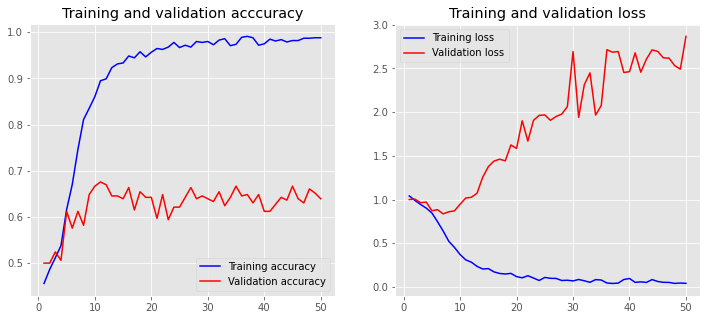

In [43]:
history = model.fit(X_train, y_train,
                    epochs = 25,
                    verbose = False,
                    validation_data = (X_test, y_test),
                    batch_size = 20)

loss, accuracy = model.evaluate(X_train, y_train, verbose = False)
print('Training Accuracy: {:.4f}'.format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose = False)
print('Testing Accuracy: {:.4f}'.format(accuracy))

plot_history(history)

In [39]:
prediction_train = [i.argmax() for i in model.predict(X_train)]
prediction_test = [i.argmax() for i in model.predict(X_test)]

Y_train_hat = np.array(prediction_train)
Y_test_hat = np.array(prediction_test)
Y_train = np.array([i.argmax() for i in y_train])
Y_test = np.array([i.argmax() for i in y_test])

tp = sum((Y_test == Y_test_hat) & (Y_test == 2))
tn = sum((Y_test == Y_test_hat) & (Y_test != 2))
fp = sum((Y_test != Y_test_hat) & (Y_test_hat == 2))
fn = sum((Y_test != Y_test_hat) & (Y_test == 2))

precision = tp/(tp+fp)
recall = tp/(tp+fn)

f1 = 2 * precision * recall / (precision + recall)
precision, recall, f1

(0.7333333333333333, 0.7236842105263158, 0.7284768211920529)

In [44]:
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model

In [45]:
model_json = model.to_json()

with open("model_.json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights("model_.h5")

In [46]:
json_file = open('model_800.json', 'r')

loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights("model_800.h5")

OSError: Unable to open file (unable to open file: name = 'model_800.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)